In [37]:
import torch, torchvision
from torch.utils.data import Dataset
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms as transforms

In [2]:
processor = OwlViTProcessor.from_pretrained("C:/Projects/ObjectDetection/transformers/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("C:/Projects/ObjectDetection/transformers/owlvit-base-patch32")

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [3]:
image = Image.open("C:\Projects\ObjectDetection\data\order_images\order_photo_1.jpeg")
texts = [[ "food item", "a grocery item", "a packet", "fruits"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

score_threshold = 0.1
thresholded_boxes = []
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    if score >= score_threshold:
      thresholded_boxes.append(box)
      #print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

In [35]:
transform = transforms.Compose([
    transforms.PILToTensor()
])

img_tensor = transform(image)

In [36]:
detected_objects  = []
for detect in thresholded_boxes:
    box = torch.tensor(detect, dtype=int)
    object_tensor = (img_tensor[:, box[1]:box[3], box[0]:box[2]])/255
    detected_objects.append(object_tensor)
                     

C:\Users\mithu\AppData\Local\Temp\ipykernel_14772\2206010338.py:3: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  box = torch.tensor(detect, dtype=int)


In [60]:
template1 = Image.open("..\\data\\template_images\\paneer.jpeg").convert('RGB')
template1_tensor = transform(template1)/255

template2 = Image.open("..\\data\\template_images\\bread.jpeg").convert('RGB')
template2_tensor = transform(template2)/255

In [36]:
path = r"..\data\template_images\paneer.jpeg"

In [41]:
template1 = Image.open("..\\data\\template_images\\paneer.jpeg").convert('RGB')

c:\Users\mithu\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [51]:
template1_tensor.min(), template1_tensor.max()

(tensor(0.0235), tensor(0.9765))

In [38]:
barlow_model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')

Using cache found in C:\Users\mithu/.cache\torch\hub\facebookresearch_barlowtwins_main
c:\Users\mithu\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mithu\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [61]:
template1_representation = barlow_model(template1_tensor.unsqueeze(0))
object_representation = barlow_model(detected_objects[0].unsqueeze(0))

template2_representation = barlow_model(template2_tensor.unsqueeze(0))

In [62]:
torch.dot(template1_representation[0],object_representation[0])

tensor(1.3130, grad_fn=<DotBackward0>)

In [63]:
torch.dot(template2_representation[0],object_representation[0])

tensor(0.9015, grad_fn=<DotBackward0>)

In [66]:
cosi = torch.nn.CosineSimilarity(dim=0)
cosi(template1_representation[0], object_representation[0])

tensor(0.9178, grad_fn=<SumBackward1>)

In [67]:
cosi(template2_representation[0], object_representation[0])

tensor(0.8464, grad_fn=<SumBackward1>)

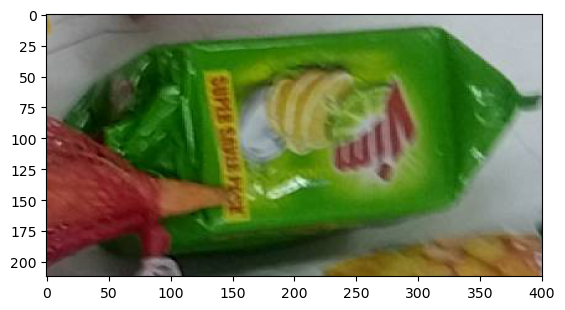

In [70]:
plt.imshow(detected_objects[3].permute(1,2,0))

#### Data
order(i), item(i,j), present/missing/incorrect
1. filter order with atleast 1 missing item
2. order with number of items b/w 3 and 10
3. orders with number of FnV items < 50% of total items

### Metrics
%-age missing items identified   
%-age presennt items identified 

#### Evaluation
order_id, order_photo -> *[ object1, object2, object3 ]* -> *[ b1, b2, b3, ..., bn ]* -> ors = *[ or1, or2, or3, ..., orn ]*  
order_id, *[ [template11, template12], [template21, template22] ]* -> trs = *[ [tr11, tr12], [tr21, tr22] ]*  
similarity( ors * trs )  

#### Pipeline
1. take order o(i)
2. pass the order through the region proposal network : k regions proposed
3. get embeddings for each object / region proposed : k*100
4. get the template (front facing) of all the items in the order : t templates
4. get embeddings of all the template images : t*100
6. cosine similarity b/w each t and each k: cosim(t,k)
7. if cosim >= threshold, 1,0 => argmax(t*k) over t


do for 5000 orders and check

In [4]:
from scipy.spatial.distance import cdist

In [11]:
a = torch.tensor([[1,1],[1,0],[0,1]], dtype=float)
b = torch.tensor([[-1,-1],[-1,0],[0,-1], [1,1], [0,1]], dtype=float)

#cdist(a,b)

In [12]:
cosi = torch.nn.CosineSimilarity(dim=1)

In [26]:
a = np.array([[1,1],[1,0],[0,1]], dtype=float)
a_hat = a/np.linalg.norm(a,axis=-1).reshape(a.shape[0],1)
b = np.array([[-1,-1],[-1,0],[0,-1], [1,1], [0,1]], dtype=float)
b_hat = b/np.linalg.norm(b,axis=-1).reshape(b.shape[0],1)
cdist(a,b)

array([[2.82842712, 2.23606798, 2.23606798, 0.        , 1.        ],
       [2.23606798, 2.        , 1.41421356, 1.        , 1.41421356],
       [2.23606798, 1.41421356, 2.        , 1.        , 0.        ]])

In [31]:
sim_metric = 1-cdist(a_hat,b_hat)

In [34]:
np.max(sim_metric >= 0.5, axis = 1)
# store these predictions for that order_id

array([ True, False,  True])

In [35]:
# template_image index, get barlow-twins emebedding, store embeddings
# do a look of the index based on item in the order and retrieve embeddings
# continue the inference pipeline